In [11]:
import torch
from torch import nn
import torch_geometric
import e3nn
import matplotlib.pyplot as plt
import urllib.request
import numpy as np

(2048, 12, 2)


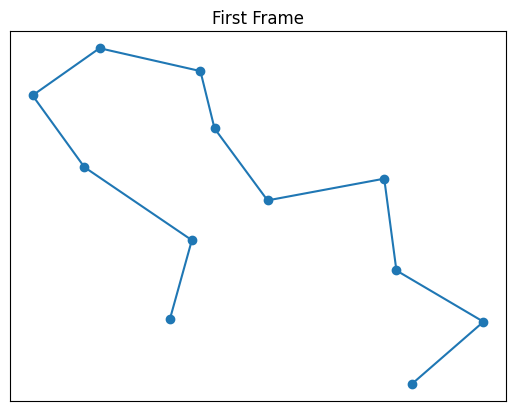

In [5]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/main/data/paths.npz", "../data/paths.npz"
)
paths = np.load("../data/paths.npz")["arr"]
print(paths.shape)
# plot the first frame
plt.title("First Frame")
plt.plot(paths[0, :, 0], paths[0, :, 1], "o-")
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
traj_3d = np.array([])
for i in range(2048):
    for j in range(12):
        TBA = paths[i][j]
        TBA = np.append(TBA, np.array([0.00]))
        traj_3d = np.append(traj_3d, TBA)

traj_3d = traj_3d.reshape(2048, 12, 3)

In [7]:
features = traj_3d[:-1]
labels = traj_3d[1:]

print(features.shape)
# split data 80:20
training_set = features[:1637]
training_labels = labels[:1637]
valid_set = features[1637:]
valid_labels = labels[1637:]

(2047, 12, 3)


In [8]:
def mse(y, yhat):
    return np.mean((yhat - y) ** 2)

success! they match!
0


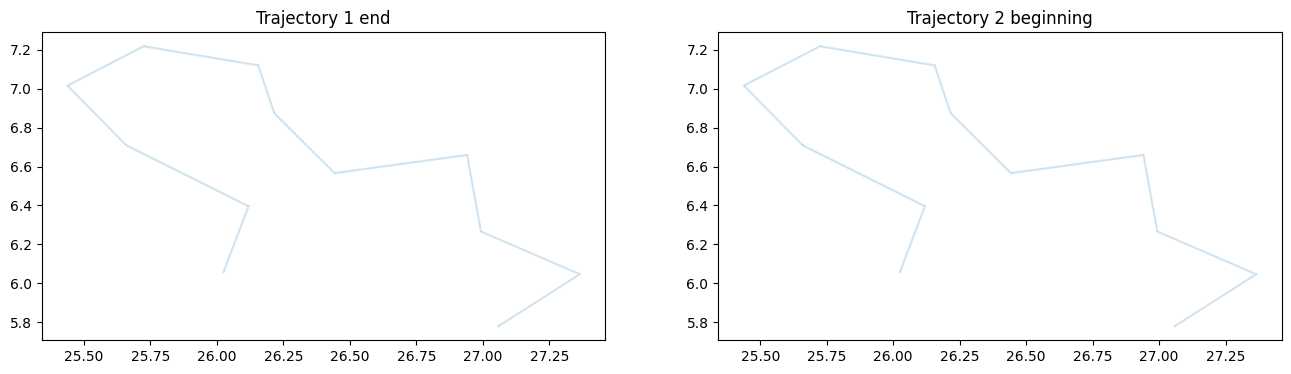

In [10]:
if mse(features[1], labels[0]) == 0:
    print("success! they match!")
else:
    print(mse(features[1], labels[0]))
    
fig, axs = plt.subplots(ncols=2, nrows=1, squeeze=True, figsize=(16, 4))
axs[0].set_title("Trajectory 1 end")
axs[1].set_title("Trajectory 2 beginning")

for i in range(0, 1, 16):
    print(i)
    axs[0].plot(features[i, :, 0], features[i, :, 1], ",-", alpha=0.2)
    axs[1].plot(labels[i, :, 0], labels[i, :, 1], ",-", alpha=0.2)   
# for i in range(2):
#     axs[i].set_xticks([])
#     axs[i].set_yticks([])

In [21]:
# create baseline model

class BaseLineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 3)
        
        
    def forward(self, x):
        logits = self.lin1(x)
        return logits
        
model = BaseLineModel()

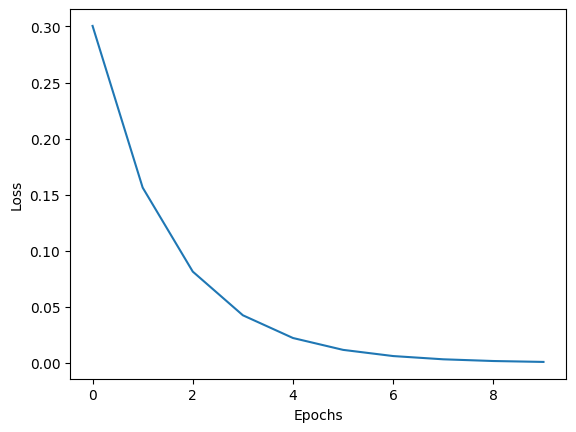

In [22]:
# training
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 10

def train(x, y, model, loss_fn, optimizer):
    model.train()
    
    # forward pass
    logits = model(x)
    
    # loss
    loss = loss_fn(logits, y)
    
    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), logits
    
baseline_train_loss = []
yst = []
y_hats = []

for epoch in range(epochs):
    for frame in range(1637):
        inputs = torch.tensor(training_set[frame]).to(torch.float32)
        labels = torch.tensor(training_labels[frame]).to(torch.float32)
        loss, y_hat = train(inputs, labels, model, loss_fn, optimizer)
        if frame % 10 == 0:
            yst.append(labels)
            y_hats.append(y_hat.detach().numpy())
        
    if epoch % 1 == 0:
        baseline_train_loss.append(loss)
    
plt.plot(baseline_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [52]:
print(len(yst))
print(yst[0])
print(y_hats[0])

1640
tensor([[26.0252,  6.0580,  0.0000],
        [26.1189,  6.3960,  0.0000],
        [25.6597,  6.7089,  0.0000],
        [25.4381,  7.0162,  0.0000],
        [25.7244,  7.2186,  0.0000],
        [26.1555,  7.1205,  0.0000],
        [26.2159,  6.8746,  0.0000],
        [26.4425,  6.5665,  0.0000],
        [26.9411,  6.6596,  0.0000],
        [26.9931,  6.2661,  0.0000],
        [27.3651,  6.0464,  0.0000],
        [27.0581,  5.7789,  0.0000]])
[[  9.848825  -14.0994625   6.0059156]
 [  9.77981   -14.308672    6.1925907]
 [  9.478798  -14.25906     6.3075085]
 [  9.282738  -14.31254     6.4447193]
 [  9.3413925 -14.540411    6.580922 ]
 [  9.560421  -14.683897    6.5753546]
 [  9.666498  -14.589001    6.4531765]
 [  9.864941  -14.537321    6.316082 ]
 [ 10.05126   -14.805618    6.417637 ]
 [ 10.201626  -14.633896    6.2174053]
 [ 10.4344845 -14.690847    6.142005 ]
 [ 10.388037  -14.421486    5.9695215]]


[28.459747 28.022722 27.973701 28.266748 28.089905 28.305958 28.555035
 28.905758 28.728815 29.344566 29.477655 29.075014]


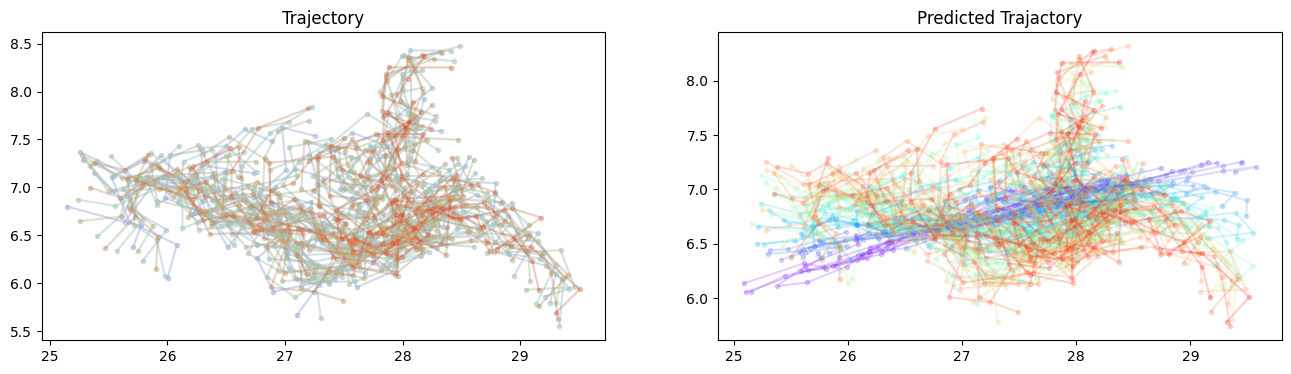

In [53]:
fig, axs = plt.subplots(ncols=2, squeeze=True, figsize=(16, 4))

y_st = np.stack(yst, axis=0)
y_hat = np.stack(y_hats, axis=0)

print(y_hat[1639, :, 0])
axs[0].set_title("Trajectory")
axs[1].set_title("Predicted Trajactory")

cmap = plt.get_cmap("rainbow")
for i in range(1, y_st.shape[0], 10):
    axs[0].plot(
        y_st[i, :, 0], y_st[i, :, 1], ".-", alpha=0.2, color=cmap(i / y_st.shape[0])
    )
    axs[1].plot(
        y_hat[i, :, 0], y_hat[i, :, 1], ".-", alpha=0.2, color=cmap(i / y_st.shape[0])
    )